## Background

This project will explore a anonymous data set. While the meaning of each column is not known, a simple K Nearest Neighbors algorithm will be applied to quickly train the model that can classify the target variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data exploration

In [2]:
df = pd.read_csv('Data/KNN_Project_Data')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
XVPM            1000 non-null float64
GWYH            1000 non-null float64
TRAT            1000 non-null float64
TLLZ            1000 non-null float64
IGGA            1000 non-null float64
HYKR            1000 non-null float64
EDFS            1000 non-null float64
GUUB            1000 non-null float64
MGJM            1000 non-null float64
JHZC            1000 non-null float64
TARGET CLASS    1000 non-null int64
dtypes: float64(10), int64(1)
memory usage: 86.1 KB


In [4]:
df.isnull().any()

XVPM            False
GWYH            False
TRAT            False
TLLZ            False
IGGA            False
HYKR            False
EDFS            False
GUUB            False
MGJM            False
JHZC            False
TARGET CLASS    False
dtype: bool

In [5]:
df.head()

,XVPM,GWYH,TRAT,TLLZ,IGGA,HYKR,EDFS,GUUB,MGJM,JHZC,TARGET CLASS
0,1636.670614,817.988525,2565.995189,358.347163,550.417491,1618.870897,2147.641254,330.727893,1494.878631,845.136088,0
1,1013.402760,577.587332,2644.141273,280.428203,1161.873391,2084.107872,853.404981,447.157619,1193.032521,861.081809,1
2,1300.035501,820.518697,2025.854469,525.562292,922.206261,2552.355407,818.676686,845.491492,1968.367513,1647.186291,1
3,1059.347542,1066.866418,612.000041,480.827789,419.467495,685.666983,852.867810,341.664784,1154.391368,1450.935357,0
4,1018.340526,1313.679056,950.622661,724.742174,843.065903,1370.554164,905.469453,658.118202,539.459350,1899.850792,0


All data is numeric and contains no missing values.

## Train and Test split

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop('TARGET CLASS',axis=1)
y = df['TARGET CLASS']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

## Preprocessing: standarization

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 1. Model training: KNN - manual hyperparameter optimization

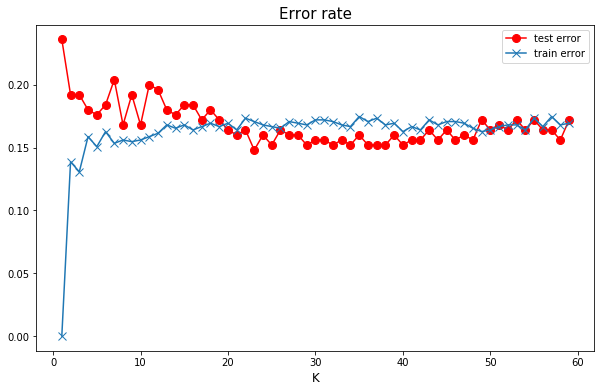

In [9]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
error_rate_train = []

for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))
    
    knn_train = KNeighborsClassifier(n_neighbors=i)
    knn_train.fit(X_train_scaled,y_train)
    knn_train_pred_i = knn_train.predict(X_train_scaled)
    error_rate_train.append(np.mean(knn_train_pred_i != y_train))

    
plt.figure(figsize=(10,6))
plt.plot(list(range(1,60)),error_rate,marker='o',markersize=8,label='test error',c='red')
plt.plot(list(range(1,60)),error_rate_train,marker='x',markersize=8,label='train error')
plt.xlabel('K',fontsize=12)
plt.title('Error rate',fontsize=15)
plt.legend()
plt.show()

In [10]:
print('Best n_neig: {}'.format(np.argmin(error_rate)+1))
print('Minimum loss attained: {:.4f}'.format(np.min(error_rate)))

Best n_neig: 23
Minimum loss attained: 0.1480


### KNN model with K = 23

In [11]:
knn = KNeighborsClassifier(n_neighbors=23).fit(X_train_scaled,y_train)

### Predictions and Evaluations

In [12]:
from sklearn.metrics import classification_report,confusion_matrix
y_predict = knn.predict(X_test_scaled)

In [13]:
pd.DataFrame(confusion_matrix(y_test,y_predict),index=['True 0','True 1'],
             columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
True 0,110,26
True 1,11,103


In [14]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       136
           1       0.80      0.90      0.85       114

    accuracy                           0.85       250
   macro avg       0.85      0.86      0.85       250
weighted avg       0.86      0.85      0.85       250



### KNN model with K = 1 (for comparison)

In [15]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled,y_train)
y_predict = knn.predict(X_test_scaled)
pd.DataFrame(confusion_matrix(y_test,y_predict),index=['True 0','True 1'],
             columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
True 0,101,35
True 1,24,90


In [16]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       136
           1       0.72      0.79      0.75       114

    accuracy                           0.76       250
   macro avg       0.76      0.77      0.76       250
weighted avg       0.77      0.76      0.76       250



## Hyperparameter optimization: Sequential model based optimization (SMBO) with Tree Parzen Estimator (TPE) surrogate model vs. Random search

In [17]:
from hyperopt import hp,tpe,rand,fmin,Trials

In [18]:
def objective_func(args):
    n_neig = args['n_neig']
    algo = args['algo']
    leaf_size = args['leaf_size']
    metric = args['metric']
    clf = KNeighborsClassifier(n_neighbors=n_neig,algorithm=algo,leaf_size=leaf_size,metric=metric).fit(X_train_scaled,y_train)
    y_predict = clf.predict(X_test_scaled)
    error_rate = np.mean(y_predict != y_test)
    return error_rate
neig_list = range(1,60)
algo_list = ['ball_tree','kd_tree']
leaf_list = range(1,60)
metric_list = ['euclidean','manhattan','chebyshev','minkowski']
space = {'n_neig':hp.choice('n_neig',neig_list),
        'algo':hp.choice('algo',algo_list),
        'leaf_size':hp.choice('leaf_size',leaf_list),
        'metric':hp.choice('metric',metric_list)}
tpe_trials = Trials()
rand_trials = Trials()

In [19]:
max_eval = 2000
best_clf_tpe = fmin(objective_func,space,algo=tpe.suggest,trials=tpe_trials,max_evals=max_eval)
best_clf_rand = fmin(objective_func,space,algo=rand.suggest,trials=rand_trials,max_evals=max_eval)

100%|██████████| 2000/2000 [00:25<00:00, 79.32it/s, best loss: 0.148]


In [20]:
print('<tpe surrogate>')
print('Best algo: {}'.format(algo_list[best_clf_tpe['algo']]))
print('Best metric: {}'.format(metric_list[best_clf_tpe['metric']]))
print('Best leaf size: {:.0f}'.format(leaf_list[best_clf_tpe['leaf_size']]))
print('Best n_neig: {:.0f}'.format(neig_list[best_clf_tpe['n_neig']]))
print('Minimum loss attained: {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Number of trials needed to attain minimum: {}'.format(tpe_trials.best_trial['misc']['idxs']['n_neig'][0]))
print('--'*25)
print('<random search>')
print('Best algo: {}'.format(algo_list[best_clf_rand['algo']]))
print('Best metric: {}'.format(metric_list[best_clf_rand['metric']]))
print('Best leaf size: {:.0f}'.format(leaf_list[best_clf_rand['leaf_size']]))
print('Best n_neig: {:.0f}'.format(neig_list[best_clf_rand['n_neig']]))
print('Minimum loss attained: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Number of trials needed to attain minimum: {}'.format(rand_trials.best_trial['misc']['idxs']['n_neig'][0]))

<tpe surrogate>
Best algo: kd_tree
Best metric: euclidean
Best leaf size: 59
Best n_neig: 23
Minimum loss attained: 0.1480
Number of trials needed to attain minimum: 47
--------------------------------------------------
<random search>
Best algo: ball_tree
Best metric: minkowski
Best leaf size: 40
Best n_neig: 23
Minimum loss attained: 0.1480
Number of trials needed to attain minimum: 236


In [21]:
results_tpe = pd.DataFrame({'iteration':tpe_trials.idxs_vals[0]['n_neig'],
                            'loss':[x['loss'] for x in tpe_trials.results],
                            'n_neig':[neig_list[idx] for idx in tpe_trials.idxs_vals[1]['n_neig']],
                            'algo':[algo_list[idx] for idx in tpe_trials.idxs_vals[1]['algo']],
                            'leaf_size':[leaf_list[idx] for idx in tpe_trials.idxs_vals[1]['leaf_size']],
                            'metric':[metric_list[idx] for idx in tpe_trials.idxs_vals[1]['metric']]})
results_rand = pd.DataFrame({'iteration':rand_trials.idxs_vals[0]['n_neig'],
                             'loss':[x['loss'] for x in rand_trials.results],
                             'n_neig':[neig_list[idx] for idx in rand_trials.idxs_vals[1]['n_neig']],
                             'algo':[algo_list[idx] for idx in rand_trials.idxs_vals[1]['algo']],
                             'leaf_size':[leaf_list[idx] for idx in rand_trials.idxs_vals[1]['leaf_size']],
                             'metric':[metric_list[idx] for idx in rand_trials.idxs_vals[1]['metric']]})

In [22]:
print('<SMBO search example>')
results_tpe.head()

<SMBO search example>


,iteration,loss,n_neig,algo,leaf_size,metric
0,0,0.164,56,ball_tree,1,minkowski
1,1,0.160,47,ball_tree,55,minkowski
2,2,0.164,57,ball_tree,6,euclidean
3,3,0.180,25,ball_tree,7,manhattan
4,4,0.164,52,kd_tree,52,minkowski


In [23]:
print('<random search example>')
results_rand.head()

<random search example>


,iteration,loss,n_neig,algo,leaf_size,metric
0,0,0.164,54,ball_tree,13,minkowski
1,1,0.164,56,kd_tree,29,euclidean
2,2,0.152,25,ball_tree,30,euclidean
3,3,0.160,28,ball_tree,13,minkowski
4,4,0.160,35,kd_tree,1,minkowski


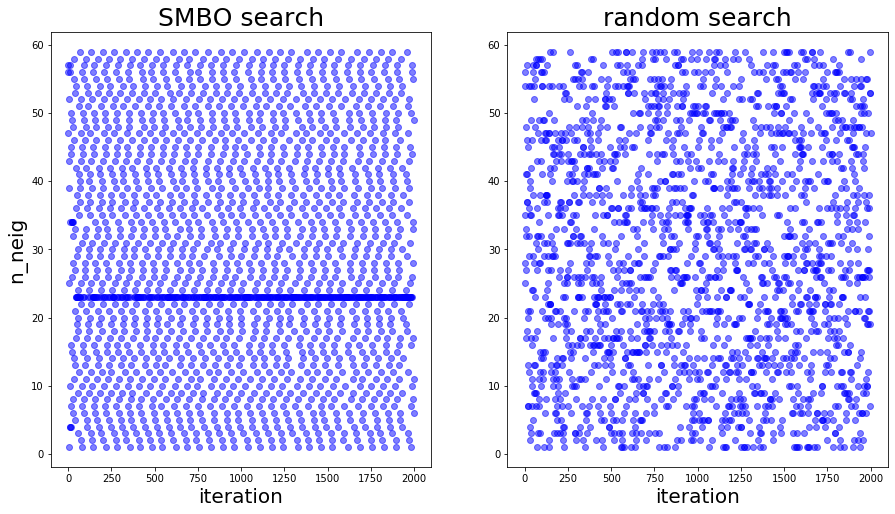

In [24]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
axes[0].plot(results_tpe['iteration'],results_tpe['n_neig'],'bo',alpha = 0.5)
axes[0].set_title('SMBO search',size=25)
axes[0].set_xlabel('iteration',size=20)
axes[0].set_ylabel('n_neig',size=20)
axes[1].plot(results_tpe['iteration'],results_rand['n_neig'],'bo',alpha = 0.5)
axes[1].set_title('random search',size=25)
axes[1].set_xlabel('iteration',size=20)
plt.show()

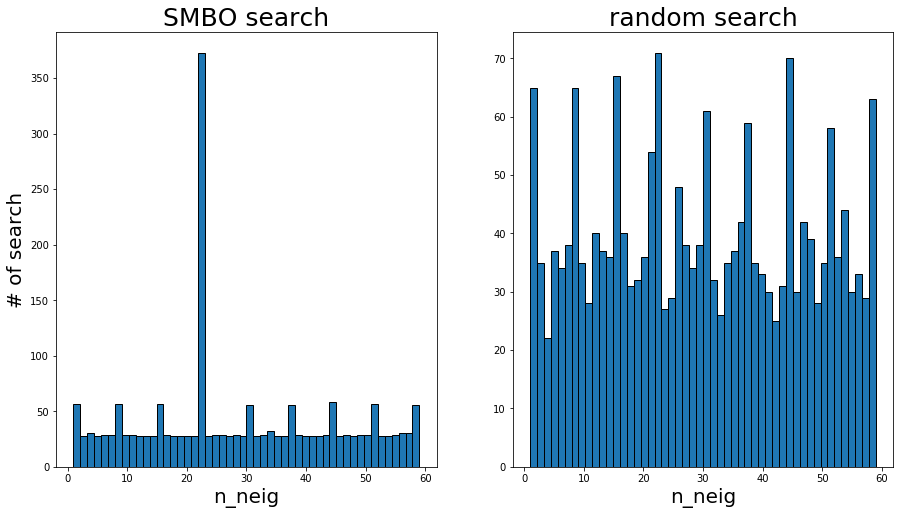

In [25]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
axes[0].hist(results_tpe['n_neig'],bins=50,edgecolor ='k')
axes[0].set_title('SMBO search',size=25)
axes[0].set_xlabel('n_neig',size=20)
axes[0].set_ylabel('# of search',size=20)
axes[1].hist(results_rand['n_neig'],bins=50,edgecolor ='k')
axes[1].set_title('random search',size=25)
axes[1].set_xlabel('n_neig',size=20)
plt.show()

In [26]:
knn = KNeighborsClassifier(n_neighbors=23,algorithm='kd_tree',metric='euclidean',leaf_size=59).fit(X_train_scaled,y_train)
y_predict = knn.predict(X_test_scaled)
pd.DataFrame(confusion_matrix(y_test,y_predict),index=['True 0','True 1'],
             columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
True 0,110,26
True 1,11,103


In [27]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       136
           1       0.80      0.90      0.85       114

    accuracy                           0.85       250
   macro avg       0.85      0.86      0.85       250
weighted avg       0.86      0.85      0.85       250



# Conclusion
For the given anonymous dataset, a simple KNN algorithm was quickly applied in an attempt to classify the target variables into 0 or 1. When K=1, the f1-score was ~0.76, but based on the "Error rate" figure, it can be seen that the model was overfitting in this case. By manually chossing **K=23**, the model could not only generalize, but also maximize the classification performance to (f1-score: 0.85) on the test set.

The manual hyperparameter optimization is error-prone and inefficient. Therefore, two automated hyperparameter optimization algorithms were implemented for comparison. While the ***random search*** is popular to fine-tune the hyperparameters in many cases, it can be very computationally expensive and inefficient when the hyperparameter space or model is complex as the tuning process does not depend on the previous optimization trials. On the other hand, the ***Bayseian-based method (sequential model based optimization (SMBO))*** does indeed get feedbacks from the previous optimization trials and only focus on the specific region of the hyperparameter space that is likely to improve the model performance. Due to the extreme simplicity of the given dataset, all the optimization methods tried resulted in the same f1-score.